# Deadly Police Encounters - Modeling and Analysis

Amanda Cheney  
Metis Project 3  
Part 2 of 2  
October 28, 2020  

**Objective** 

Build a classification model that can identify where deadly encounters are likely to happen based on socio-economic characteristics of the communities in which they occur. 

**Data Sources** 

The [Mapping Police Violence](https://mappingpoliceviolence.org/) project which has data on all deadly police encounters nationwide that including information about the precise location of the killing as well as information about the victim’s race. 

[American Community Survey Data](https://www.census.gov/programs-surveys/acs) from the US Census Bureau which has data on key socio-economic indicators like education, unemployment, rates of health insurance coverage, use of food stamps, computer ownership and access to the internet – nearly all of which the ACS offers data on by racial/ ethnic categories.  

Since the Mapping Police Violence data has zip code information for its entire dataset of all deadly encounters – my observations are individual zip codes. So for all zip codes in entire the United States, my model seeks to explain which zip codes have deadly encounters in which people of color are killed by police and which zip codes do not by comparing their socio-economic characteristics.  

**Note**: I have retained the original ACS codes for all of my features throughout this notebook until the section on feature importance where I provide descriptions of the top 10 most important features. For interpreation of all other feature variables, please consult the Project 3 Codebook file.

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import statistics

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, fbeta_score, log_loss, make_scorer
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, auc
from sklearn.metrics import fbeta_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_recall_fscore_support

import psycopg2 as pg

## Loading the Data from SQL

In [2]:
# pip install psycopg2

In [3]:
connection_args = {
   'host': 'localhost', #connecting to local version of psql
    'dbname': 'deadly_encounters_db', #DB connecting to 
    'port': 5432 #port opened on AWS
}
connection = pg.connect(**connection_args)

In [4]:
query = "SELECT * from deadly_encounters_zipcodes;"

df_returned = pd.read_sql(query, connection)
df_returned.shape

(28081, 51)

In [5]:
df_copy = df_returned.copy()

In [6]:
df_copy.columns

Index(['zip_code_tabulation_area', 's0101_c01_001e', 's1903_c03_001e',
       's1903_c03_003e', 's1903_c03_009e', 's1903_c03_010e', 'dp05_0078pe',
       'dp05_0071pe', 'dp05_0077pe', 'dp02_0066pe', 'dp02_0067pe',
       's2701_c03_001e', 's2701_c03_017e', 's2701_c03_023e', 's2701_c03_024e',
       's2701_c05_001e', 's2701_c03_038e', 's2701_c03_039e', 's2701_c03_044e',
       's2701_c03_045e', 's2701_c03_046e', 's2201_c02_021e', 's2201_c02_022e',
       's2201_c04_001e', 's2201_c04_009e', 's2201_c04_013e', 's2201_c04_026e',
       's2201_c04_032e', 's2201_c04_033e', 's2201_c02_036e', 's2301_c04_001e',
       's2301_c04_006e', 's2301_c04_020e', 's2301_c04_013e', 's2301_c04_019e',
       's2301_c04_021e', 's2301_c04_022e', 's2301_c04_023e', 's2301_c04_032e',
       's2301_c04_033e', 's2802_c05_001e', 's2802_c05_006e', 's2802_c05_012e',
       's2802_c05_013e', 's2802_c07_001e', 's2802_c07_006e', 's2802_c07_012e',
       's2802_c07_013e', 'deadly_encounter', 'poc', 'bi_poc'],
      dtype=

In [7]:
df_copy.rename(str.upper, axis='columns', inplace=True ) # make Census feature names capital again for consistency
df_copy.rename(columns={'DEADLY_ENCOUNTER':'deadly_encounter' , 'POC':'poc', 'BI_POC':'bi_poc'}, inplace=True) #lowercase other engineered features

In [8]:
df_copy.columns

Index(['ZIP_CODE_TABULATION_AREA', 'S0101_C01_001E', 'S1903_C03_001E',
       'S1903_C03_003E', 'S1903_C03_009E', 'S1903_C03_010E', 'DP05_0078PE',
       'DP05_0071PE', 'DP05_0077PE', 'DP02_0066PE', 'DP02_0067PE',
       'S2701_C03_001E', 'S2701_C03_017E', 'S2701_C03_023E', 'S2701_C03_024E',
       'S2701_C05_001E', 'S2701_C03_038E', 'S2701_C03_039E', 'S2701_C03_044E',
       'S2701_C03_045E', 'S2701_C03_046E', 'S2201_C02_021E', 'S2201_C02_022E',
       'S2201_C04_001E', 'S2201_C04_009E', 'S2201_C04_013E', 'S2201_C04_026E',
       'S2201_C04_032E', 'S2201_C04_033E', 'S2201_C02_036E', 'S2301_C04_001E',
       'S2301_C04_006E', 'S2301_C04_020E', 'S2301_C04_013E', 'S2301_C04_019E',
       'S2301_C04_021E', 'S2301_C04_022E', 'S2301_C04_023E', 'S2301_C04_032E',
       'S2301_C04_033E', 'S2802_C05_001E', 'S2802_C05_006E', 'S2802_C05_012E',
       'S2802_C05_013E', 'S2802_C07_001E', 'S2802_C07_006E', 'S2802_C07_012E',
       'S2802_C07_013E', 'deadly_encounter', 'poc', 'bi_poc'],
      dtype=

In [9]:
df_copy.shape 

(28081, 51)

In [10]:
X = df_copy[['S0101_C01_001E', 'S1903_C03_001E',
       'S1903_C03_003E', 'S1903_C03_009E', 'S1903_C03_010E', 'DP05_0078PE',
       'DP05_0071PE', 'DP05_0077PE', 'DP02_0066PE', 'DP02_0067PE',
       'S2701_C03_001E', 'S2701_C03_017E', 'S2701_C03_023E', 'S2701_C03_024E',
        'S2701_C03_038E', 'S2701_C03_039E', 'S2701_C03_044E',
       'S2701_C03_045E', 'S2701_C03_046E', 'S2201_C02_021E', 
       'S2201_C04_001E', 'S2201_C04_009E', 'S2201_C04_013E', 'S2201_C04_026E',
       'S2201_C04_032E', 'S2201_C04_033E', 'S2201_C02_036E', 'S2301_C04_001E',
       'S2301_C04_006E', 'S2301_C04_020E', 'S2301_C04_013E', 'S2301_C04_019E',
       'S2301_C04_021E', 'S2301_C04_022E', 'S2301_C04_023E', 'S2301_C04_032E',
       'S2301_C04_033E', 'S2802_C05_001E', 'S2802_C05_006E', 'S2802_C05_012E',
       'S2802_C05_013E', 'S2802_C07_001E', 'S2802_C07_006E', 'S2802_C07_012E',
       'S2802_C07_013E']]

In [11]:
X.shape

(28081, 45)

In [12]:
y = df_copy['bi_poc']

In [13]:
y.shape

(28081,)

## Identifying Class Imbalance

/Users/AmandaCheney/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


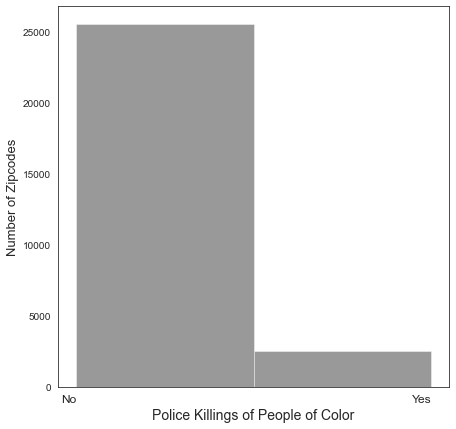

In [14]:
sns.set_style("white")
plt.figure(figsize=(7,7))
# plt.xticks(np.arange(2), labels=['No police killings of PoC', 'Police have killed PoC'])

plt.xticks(ticks=np.arange(2))
distribution = sns.distplot(y, kde=False, bins=2, color='black')
distribution.set_xticklabels(labels=['No', 'Yes'], fontdict={'fontsize':12, 'horizontalalignment':'right'})
plt.xlabel('Police Killings of People of Color', fontsize=14)
plt.ylabel('Number of Zipcodes', fontsize=13)
# plt.title("Deadly Encounters Happen in a small % of zipcodes", fontsize=18)
plt.savefig('Imbalance');

### Implications of Class Imbalance for Model Evaluation  
**Importance of Recall**  
Only 9% of all US zip codes account for all police killings of people of color between 2013-2020. Therefore I will select the best model based on which model can offer the best recall score for the positive/minority class (where people of color are killed by police). I will put special emphasis on ensuring that recall for the minority class is as high as possible even if  precision is low because compared to the cost of a human life, which economists estimate is $10 million and that person's family would regard as priceless, the cost of falsely identifying a zip code as having a deadly encounter when it does not is several orders of magnitude less important than the cost of falsely predicting that a zip code does not have a deadly encounter when it in fact has. 

## Train-Test Splitting

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y)

In [16]:
X_train.shape, X_test.shape

((22464, 45), (5617, 45))

## Baseline Modelling and Sampler Selection

Although EDA has already shown that the classes are very imbalanced, I run a few baseline models without regard for class weight which have deceptively good accuracy despite having very poor recall for the minority class - which is what I am most interested in explaining. I do this to motivate how much improvement I will need to make to build useful model in the following sub-section.

#### KNN 

In [17]:
knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Training set: ", knn.score(X_train, y_train))
print("Test set: ", knn.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Training set:  0.9234330484330484
Test set:  0.9173936264910094
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      5108
         1.0       0.64      0.21      0.31       509

    accuracy                           0.92      5617
   macro avg       0.78      0.60      0.63      5617
weighted avg       0.90      0.92      0.90      5617



#### Logistic Regression

In [18]:
log_reg = LogisticRegression(max_iter=5000, n_jobs=-1, random_state=44)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print("Training set: ", log_reg.score(X_train, y_train))
print("Test set: ", log_reg.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Training set:  0.9193376068376068
Test set:  0.9189959052875201
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96      5108
         1.0       0.62      0.27      0.38       509

    accuracy                           0.92      5617
   macro avg       0.78      0.63      0.67      5617
weighted avg       0.90      0.92      0.90      5617



In [19]:
rfc = RandomForestClassifier(n_jobs = -1, random_state=44)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print("Training set: ", rfc.score(X_train, y_train))
print("Test set: ", rfc.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Training set:  1.0
Test set:  0.9222004628805412
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      5108
         1.0       0.68      0.27      0.39       509

    accuracy                           0.92      5617
   macro avg       0.80      0.63      0.67      5617
weighted avg       0.91      0.92      0.91      5617



In [20]:
bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(X_train, y_train)
y_pred = bernoulli_nb.predict(X_test)
print("Training set: ", bernoulli_nb.score(X_train, y_train))
print("Test set: ", bernoulli_nb.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Training set:  0.796340811965812
Test set:  0.7997151504361759
              precision    recall  f1-score   support

         0.0       0.98      0.80      0.88      5108
         1.0       0.29      0.81      0.42       509

    accuracy                           0.80      5617
   macro avg       0.63      0.80      0.65      5617
weighted avg       0.91      0.80      0.84      5617



In [21]:
svc = SVC(random_state=44)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print("Training set: ", svc.score(X_train, y_train))
print("Test set: ", svc.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Training set:  0.912170584045584
Test set:  0.9122307281466975
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      5108
         1.0       0.75      0.05      0.09       509

    accuracy                           0.91      5617
   macro avg       0.83      0.52      0.52      5617
weighted avg       0.90      0.91      0.88      5617



### Over- and Undersampling
Now I run the same models using four different methods of over- and undersampling.

In [22]:
def baseline_pipeline(X, y, model_name, model, over_under_sampler):
    """ For a given dataset (X,y), classification model, and over- or undersampler,
    fits the model to over/ underasampled data, and returns classification reports."""
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y)
    
    X_over_under_sampled_train, y_over_under_sampled_train = over_under_sampler.fit_sample(
            X_train, y_train)

    model.fit(X_over_under_sampled_train, y_over_under_sampled_train)
    y_pred = model.predict(X_val)
    
    print(model_name, "using", over_under_sampler,":")
    print("Training set: ", model.score(X_train, y_train))
    print("Validation set: ", model.score(X_val, y_val))
    print(classification_report(y_val, y_pred))    

In [23]:
models = {"KNN": KNeighborsClassifier(n_neighbors=10, n_jobs=-1),
          "Logistic Reg": LogisticRegression(max_iter=5000, n_jobs=-1, random_state=44), 
          "Random Forest": RandomForestClassifier(n_jobs = -1, random_state=44),
          "BernoulliNB": BernoulliNB(),
          "SVC": SVC(random_state=44)
         }

#### RandomOverSampler

In [24]:
for model_name, model in models.items():
    baseline_pipeline(X_train, y_train, model_name, model, RandomOverSampler(random_state=44)) # call it on X_train 
    #so that still not touching actual holdout test data. 
    print(" ")

KNN using RandomOverSampler(random_state=44) :
Training set:  0.8460297145400923
Validation set:  0.7883374137547295
              precision    recall  f1-score   support

         0.0       0.96      0.80      0.87      4086
         1.0       0.26      0.70      0.38       407

    accuracy                           0.79      4493
   macro avg       0.61      0.75      0.62      4493
weighted avg       0.90      0.79      0.83      4493

 
Logistic Reg using RandomOverSampler(random_state=44) :
Training set:  0.822436147125925
Validation set:  0.8097039839750724
              precision    recall  f1-score   support

         0.0       0.98      0.81      0.89      4086
         1.0       0.30      0.82      0.44       407

    accuracy                           0.81      4493
   macro avg       0.64      0.81      0.66      4493
weighted avg       0.92      0.81      0.84      4493

 
Random Forest using RandomOverSampler(random_state=44) :
Training set:  1.0
Validation set:  0.91386

Using `RandomOverSampler` recall on the minority class has improved across the board. However, KNN and RandomForest are somwhat overfitting. The best performance so far seems to be from Logistic Regression, Naive Bayes and SVC are all offering strong, comparable recall scores, though Logistic Regression has the best precision of the three. Although recall is by far my most important classification scoring metric (because I want to ensure that I capture as many zipcodes as possible that have deadly police encounters with people of color), I also don't want to incorrectly too many zipcodes as having such deadly encounters that actually don't, if it can be helped.

#### RandomUnderSampler

In [25]:
for model_name, model in models.items():
    baseline_pipeline(X_train, y_train, model_name, model, RandomUnderSampler(random_state=44))
    print(" ")

KNN using RandomUnderSampler(random_state=44) :
Training set:  0.8059651661009404
Validation set:  0.792566214110839
              precision    recall  f1-score   support

         0.0       0.97      0.79      0.87      4086
         1.0       0.28      0.79      0.41       407

    accuracy                           0.79      4493
   macro avg       0.62      0.79      0.64      4493
weighted avg       0.91      0.79      0.83      4493

 
Logistic Reg using RandomUnderSampler(random_state=44) :
Training set:  0.8174837237771966
Validation set:  0.8039172045403962
              precision    recall  f1-score   support

         0.0       0.98      0.80      0.88      4086
         1.0       0.29      0.82      0.43       407

    accuracy                           0.80      4493
   macro avg       0.64      0.81      0.66      4493
weighted avg       0.92      0.80      0.84      4493

 
Random Forest using RandomUnderSampler(random_state=44) :
Training set:  0.8518168159813032
Valida

Using `RandomUnderSampler` overfittting is less of an issue for KNN and Random Forest than was the case with RandomOverSampler. However, the results are otherwise relatively comparable  with RandomOverSampler for Logistic Regression, Bernoulli Naive Bayes and Random Forest. 

#### SMOTE

In [26]:
for model_name, model in models.items():
    baseline_pipeline(X_train, y_train, model_name, model, SMOTE(random_state=44))
    print(" ")

KNN using SMOTE(random_state=44) :
Training set:  0.8594402092259752
Validation set:  0.8041397729801915
              precision    recall  f1-score   support

         0.0       0.96      0.82      0.88      4086
         1.0       0.27      0.69      0.39       407

    accuracy                           0.80      4493
   macro avg       0.62      0.75      0.64      4493
weighted avg       0.90      0.80      0.84      4493

 
Logistic Reg using SMOTE(random_state=44) :
Training set:  0.8226030827444216
Validation set:  0.8117070999332294
              precision    recall  f1-score   support

         0.0       0.98      0.81      0.89      4086
         1.0       0.30      0.81      0.44       407

    accuracy                           0.81      4493
   macro avg       0.64      0.81      0.66      4493
weighted avg       0.92      0.81      0.85      4493

 
Random Forest using SMOTE(random_state=44) :
Training set:  1.0
Validation set:  0.8775873581126197
              precision

Using SMOTE to oversample the minority class we see overfitting problems once again with KNN and DecisionTree. Here SVC has the best recall followed closely by Logistic Regression.

#### ADASYN

In [27]:
for model_name, model in models.items():
    baseline_pipeline(X_train, y_train, model_name, model, ADASYN(random_state=44))
    print(" ")

KNN using ADASYN(random_state=44) :
Training set:  0.8452506816537755
Validation set:  0.7912308034720676
              precision    recall  f1-score   support

         0.0       0.97      0.80      0.87      4086
         1.0       0.26      0.72      0.38       407

    accuracy                           0.79      4493
   macro avg       0.61      0.76      0.63      4493
weighted avg       0.90      0.79      0.83      4493

 
Logistic Reg using ADASYN(random_state=44) :
Training set:  0.8024038729063491
Validation set:  0.7894502559537058
              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87      4086
         1.0       0.28      0.84      0.42       407

    accuracy                           0.79      4493
   macro avg       0.63      0.81      0.65      4493
weighted avg       0.92      0.79      0.83      4493

 
Random Forest using ADASYN(random_state=44) :
Training set:  1.0
Validation set:  0.875139105274872
              precisi

Results here are relatively comparable with SMOTE and RandomOverSampler, however, ADASYN has given even better performance to SVC, Logistic Regression and Naive Bayes. At this point I decide to eliminate Random Forest and KNN as potential models. RandomForest only performs well on undersampled data, which isn't ideal because it means I don't get to train the model on as much of the data as I otherwise could, and even then is prone to overfitting and KNN simply doesn't perfom as well as the remaining three. As for over- and undersampling techniques, I get the highest recall scores using `RandomOverSampler` and `ADASYN`, so I will continue to narrow down my model selection using only these two oversamping techniques. 

## Narrowing Down Model Selection  
### Classification Scoring Metrics

Now that I have eliminated Random Forest and KNN as potential models, I look to see how well Logistic Regression, Bernoulli Naive Bayes and SVC perform when I begin to bring in more refined classification scoring metrics starting with f_beta which allows me to calculate model accuracy while accounting for the relative importance of recall compared to precision. In my case I want to use a very high beta of at least 10 because recall is at least 10 times more important than precision in this context where we are predicting where a human life may be lost. I also deploy StandardScaler to prepare for trying different regularization techniques. 

In [28]:
def average_metrics_pipeline(X, y, model_name, model, over_under_sampler, beta_value=10):
    """ For a given dataset (X,y), classification model, and over- or undersampler,
    fits the model to over/ underasampled data, and returns the weighted average 
    values for accuracy, precision, recall and fbeta classfication scoring metrics 
    across 5 cross-validated folds."""

    # setting up k-folds and dictionaries to hold results
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)
    cv_accuracy = []
    cv_precision = []
    cv_recall = []
    cv_fbeta = []

    # Render X and Y as np.arrays in order to generate indices for use with k-fold splitting
    # in order to manually keep track of which indices are being split into training/validation 
    # sets so I can over/ undersample only to the training set, which is then used to fit model
    X = np.array(X)
    y = np.array(y)
    
    for train_ind, val_ind in kf.split(X, y):

        X_train, y_train = X[train_ind], y[train_ind]
        X_over_under_sampled_train, y_over_under_sampled_train = over_under_sampler.fit_sample(
            X_train, y_train)
        X_val, y_val = X[val_ind], y[val_ind]
        
        std_scale = StandardScaler()
        X_over_under_sampled_train = std_scale.fit_transform(X_over_under_sampled_train)
        X_val = std_scale.transform(X_val)
        
        model.fit(X_over_under_sampled_train, np.array(
            y_over_under_sampled_train).ravel())
        y_pred = model.predict(X_val)
            
        # find average scoring metrics for the minority/positive class 
#         from sklearn.metrics import precision_recall_fscore_support
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        fbeta = fbeta_score(y_val, y_pred, beta=beta_value)

        cv_accuracy.append(accuracy)
        cv_precision.append(precision)
        cv_recall.append(recall)
        cv_fbeta.append(fbeta)

    # calculate means and standard deviations for each metric across all 5 kfolds 
    cv_recall = "Recall: {:.3f} +/- {:.3f}".format(statistics.mean(
        cv_recall), statistics.variance(cv_recall))
    cv_precision = "Precision: {:.3f} +/- {:.3f}".format(statistics.mean(
        cv_precision), statistics.variance(cv_precision))
    cv_fbeta = "F-beta Score: {:.3f} +/- {:.3f}".format(
        statistics.mean(cv_fbeta), statistics.variance(cv_fbeta))
    cv_accuracy = "Accuracy: {:.3f} +/- {:.3f}".format(statistics.mean(
        cv_accuracy), statistics.variance(cv_accuracy))    

    print(model_name, ":")
    print("Model score on training set: {:.3f}".format(model.score(X_over_under_sampled_train, y_over_under_sampled_train)))
    print("Model score on validation set: {:.3f}".format(model.score(X_val, y_val)))
    print(cv_recall)
    print(cv_precision)
    print(cv_fbeta)
    print(cv_accuracy)

In [29]:
models = {"Logistic Reg": LogisticRegression(max_iter=5000, random_state=44, n_jobs=-1), 
          "BernoulliNB": BernoulliNB(),
          "SVC": SVC(random_state=44),
         }

### F-beta = 10 and RandomOverSampler

In [30]:
print("Using random oversampling. All classification scoring metrics below are for the positive class, which in" "\n"
"this case is also the minority class.\n")
for model_name, model in models.items():
    average_metrics_pipeline(X_train, y_train, model_name, model, RandomOverSampler(random_state=44)) # trying w/
    # default beta = 10 
    print(" ")

Using random oversampling. All classification scoring metrics below are for the positive class, which in
this case is also the minority class.

Logistic Reg :
Model score on training set: 0.833
Model score on validation set: 0.823
Recall: 0.841 +/- 0.000
Precision: 0.312 +/- 0.000
F-beta Score: 0.827 +/- 0.000
Accuracy: 0.817 +/- 0.000
 
BernoulliNB :
Model score on training set: 0.781
Model score on validation set: 0.792
Recall: 0.758 +/- 0.001
Precision: 0.267 +/- 0.000
F-beta Score: 0.745 +/- 0.001
Accuracy: 0.790 +/- 0.000
 
SVC :
Model score on training set: 0.900
Model score on validation set: 0.830
Recall: 0.810 +/- 0.000
Precision: 0.321 +/- 0.000
F-beta Score: 0.798 +/- 0.000
Accuracy: 0.827 +/- 0.000
 


### F-beta = 20 and RandomOverSampler

In [31]:
print("Using random oversampling. All classification scoring metrics below are for the positive class, which in" "\n"
"this case is also the minority class.")
for model_name, model in models.items():
    average_metrics_pipeline(X_train, y_train, model_name, model, RandomOverSampler(random_state=44), 20)
    print(" ")

Using random oversampling. All classification scoring metrics below are for the positive class, which in
this case is also the minority class.
Logistic Reg :
Model score on training set: 0.833
Model score on validation set: 0.823
Recall: 0.841 +/- 0.000
Precision: 0.312 +/- 0.000
F-beta Score: 0.838 +/- 0.000
Accuracy: 0.817 +/- 0.000
 
BernoulliNB :
Model score on training set: 0.781
Model score on validation set: 0.792
Recall: 0.758 +/- 0.001
Precision: 0.267 +/- 0.000
F-beta Score: 0.755 +/- 0.001
Accuracy: 0.790 +/- 0.000
 
SVC :
Model score on training set: 0.900
Model score on validation set: 0.830
Recall: 0.810 +/- 0.000
Precision: 0.321 +/- 0.000
F-beta Score: 0.807 +/- 0.000
Accuracy: 0.827 +/- 0.000
 


Moving from beta = 10 to beta = 20 only gives marginally better f-beta scores. But having now scaled my data Logistic Regression is outperforming both SVC and Bernoulli Naive Bayes on recall. SVC is also starting to overfit. 

### F-beta = 10 and ADASYN

In [32]:
print("Using ADASYN. All classification scoring metrics below are for the positive class, which in" "\n"
"this case is also the minority class.")
for model_name, model in models.items():
    average_metrics_pipeline(X_train, y_train, model_name, model, ADASYN(random_state=44)) # try w/ defaul beta=10 
    print(" ")

Using ADASYN. All classification scoring metrics below are for the positive class, which in
this case is also the minority class.
Logistic Reg :
Model score on training set: 0.818
Model score on validation set: 0.807
Recall: 0.859 +/- 0.000
Precision: 0.294 +/- 0.000
F-beta Score: 0.843 +/- 0.000
Accuracy: 0.800 +/- 0.000
 
BernoulliNB :
Model score on training set: 0.771
Model score on validation set: 0.788
Recall: 0.781 +/- 0.000
Precision: 0.264 +/- 0.000
F-beta Score: 0.766 +/- 0.000
Accuracy: 0.783 +/- 0.000
 
SVC :
Model score on training set: 0.907
Model score on validation set: 0.828
Recall: 0.783 +/- 0.000
Precision: 0.323 +/- 0.000
F-beta Score: 0.772 +/- 0.000
Accuracy: 0.832 +/- 0.000
 


### F-beta = 20 and ADASYN

In [33]:
print("Using ADASYN. All classification scoring metrics below are for the positive class, which in" "\n"
"this case is also the minority class.")
for model_name, model in models.items():
    average_metrics_pipeline(X_train, y_train, model_name, model, ADASYN(random_state=44), 20) # try beta = 20
    print(" ")

Using ADASYN. All classification scoring metrics below are for the positive class, which in
this case is also the minority class.
Logistic Reg :
Model score on training set: 0.818
Model score on validation set: 0.807
Recall: 0.859 +/- 0.000
Precision: 0.294 +/- 0.000
F-beta Score: 0.855 +/- 0.000
Accuracy: 0.800 +/- 0.000
 
BernoulliNB :
Model score on training set: 0.771
Model score on validation set: 0.788
Recall: 0.781 +/- 0.000
Precision: 0.264 +/- 0.000
F-beta Score: 0.777 +/- 0.000
Accuracy: 0.783 +/- 0.000
 
SVC :
Model score on training set: 0.907
Model score on validation set: 0.828
Recall: 0.783 +/- 0.000
Precision: 0.323 +/- 0.000
F-beta Score: 0.780 +/- 0.000
Accuracy: 0.832 +/- 0.000
 


Again not much of a difference between beta=10 versus beta=20, however, ADASYN does provide better classification metrics than RandomOverSampler for all three of my model contender. Ultimately Logistic Regression continues to offer the best recall performance, but for one last check, let's compare each of the three model's ROC-AUC Curves.

In [34]:
def plot_roc_curves(X, y):
    plt.figure(figsize=(10,6))
    lw = 2
    
    # train-val split and oversample
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=.2, random_state=0)
    adasyn = ADASYN(random_state=44)
    X_oversampled_train, y_oversampled_train = adasyn.fit_sample(
        X_train, y_train)
    
    # Logistic Regression
    # fit model and predict probabilities of validation data 
    log_reg = LogisticRegression(max_iter=5000, n_jobs=-1, random_state=44)
    log_reg.fit(X_oversampled_train, y_oversampled_train)
    y_pred = log_reg.predict_proba(X_val)

    fpr, tpr, thresholds = roc_curve(y_val, y_pred[:,1])
    model_auc = roc_auc_score(y_val, y_pred[:,1])
    plt.plot(fpr, tpr, color='b',
             lw=lw, label=f'Logistic Regression, AUC: {model_auc:.4f}')

    
    # Naive Bayes 
    # fit model and predict probabilities of validation data 
    nb = BernoulliNB()
    nb.fit(X_oversampled_train, y_oversampled_train)
    y_pred = nb.predict_proba(X_val)
     
    fpr, tpr, thresholds = roc_curve(y_val, y_pred[:,1])
    model_auc = roc_auc_score(y_val, y_pred[:,1])
    plt.plot(fpr, tpr, color='r',
             lw=lw, label=f'Bernoulli Naive Bayes, AUC: {model_auc:.4f}')
       
    # SVC 
    # fit model and predict probabilities of validation data
    svc = SVC(probability=True, random_state=1)
    svc.fit(X_oversampled_train, y_oversampled_train)
    y_pred = svc.predict_proba(X_val)
     
    fpr, tpr, thresholds = roc_curve(y_val, y_pred[:,1])
    model_auc = roc_auc_score(y_val, y_pred[:,1])
    plt.plot(fpr, tpr, color='g',
             lw=lw, label=f'SVC, AUC: {model_auc:.4f}')
    
    plt.plot([0,1],[0,1],c='violet',ls='--', label='Chance Line')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curves for top 3 Contending Models')
    plt.legend(loc='lower right', prop={'size': 10}, frameon=True);
    plt.savefig('ROC Curves for top 3 Contending Models');

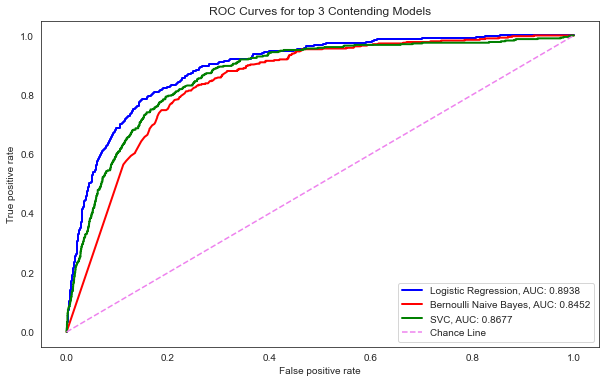

In [35]:
plot_roc_curves(X_train, y_train)

Once again, the differences in performance are somewhat marginal but Logistic Regression does take the lead and has the added benifit of high interpretability which is extremely desirable for the objectives of this project.  
So I will now proceed with using a Logistic Regression model but before I fit the final model, first let's take a closer look at tuning the hyperparameters. 

## Hyperparameter Tuning

In [36]:
def classification_reports_pipeline(X, y, model_name, model, oversampler):
    """ For a given dataset and classification model, fits the model, predicts classes of
    validation set, and returns the classification report showing precision, recall, f1 and 
    support for each class, as well as the average accuracy score. """

    X = np.array(X)
    y = np.array(y)

    # train-val split and oversample
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=.2, random_state=0)
    X_oversampled_train, y_oversampled_train = oversampler.fit_sample(
        X_train, y_train)

    # fit models

    model.fit(X_oversampled_train, np.array(y_oversampled_train).ravel())
    y_pred = model.predict(X_val)
    
    precision_recall_fscore = precision_recall_fscore_support(y_val, y_pred)
    
    majority_precision = "Majority Class Precision: {:.3f}".format(precision_recall_fscore[0][0])
    minority_precision = "Minority Class Precision: {:.3f}".format(precision_recall_fscore[0][1])

    majority_recall = "Majority Class Recall: {:.3f}".format(precision_recall_fscore[1][0])
    minority_recall = "Minority Class Recall: {:.3f}".format(precision_recall_fscore[1][1])
    
    majority_fbeta = "Majority Class F-beta: {:.3f}".format(precision_recall_fscore[2][0])
    minority_fbeta = "Minority Class F-beta: {:.3f}".format(precision_recall_fscore[2][1])

    # print classification reports
    print(model_name, ":")
    print(minority_precision)
    print(minority_recall)
    print(minority_fbeta)
    print(majority_precision)
    print(majority_recall)
    print(majority_fbeta)

In [37]:
solvers = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]

models = {}
for solver in solvers:
    models["Log Reg "+solver] = LogisticRegression(max_iter=5000, solver = solver, n_jobs=-1, random_state=44)

In [38]:
for model_name, model in models.items():
    classification_reports_pipeline(X_train, y_train, model_name, model, ADASYN(random_state=44))
    print(" ")

Log Reg newton-cg :
Minority Class Precision: 0.292
Minority Class Recall: 0.836
Minority Class F-beta: 0.433
Majority Class Precision: 0.980
Majority Class Recall: 0.797
Majority Class F-beta: 0.879
 
Log Reg lbfgs :
Minority Class Precision: 0.290
Minority Class Recall: 0.826
Minority Class F-beta: 0.429
Majority Class Precision: 0.979
Majority Class Recall: 0.798
Majority Class F-beta: 0.879
 


/Users/AmandaCheney/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Log Reg liblinear :
Minority Class Precision: 0.290
Minority Class Recall: 0.831
Minority Class F-beta: 0.430
Majority Class Precision: 0.979
Majority Class Recall: 0.796
Majority Class F-beta: 0.878
 


/Users/AmandaCheney/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Log Reg sag :
Minority Class Precision: 0.299
Minority Class Recall: 0.839
Minority Class F-beta: 0.440
Majority Class Precision: 0.980
Majority Class Recall: 0.803
Majority Class F-beta: 0.883
 
Log Reg saga :
Minority Class Precision: 0.292
Minority Class Recall: 0.822
Minority Class F-beta: 0.431
Majority Class Precision: 0.978
Majority Class Recall: 0.800
Majority Class F-beta: 0.880
 


/Users/AmandaCheney/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Sag and saga both fail to converge after 5,000 iterations. The remaining solvers, newton-cg, lbfgs and liblinear, have relatively comparable results, however,  newton-cg and lbfgs only support L2 regularization while liblinear allows for both L1 and L2. However since there is likely multi-colinearity between many of my features due to the nature of my data, I want to make sure that I am able to use the best possible regularization technique so I decide to choose liblinear as my solver. 

Now let's see which of these two regularization options give better performance. 

In [39]:
penalties = ["l1", "l2"]
models = {}
for i in penalties:
    models["Log Reg "+i] = LogisticRegression(max_iter=5000, solver="liblinear", penalty=i, random_state=44)

In [40]:
for model_name, model in models.items():
    classification_reports_pipeline(X_train, y_train, model_name, model, ADASYN(random_state=44))
    print(" ")

Log Reg l1 :
Minority Class Precision: 0.291
Minority Class Recall: 0.831
Minority Class F-beta: 0.431
Majority Class Precision: 0.979
Majority Class Recall: 0.797
Majority Class F-beta: 0.879
 
Log Reg l2 :
Minority Class Precision: 0.290
Minority Class Recall: 0.831
Minority Class F-beta: 0.430
Majority Class Precision: 0.979
Majority Class Recall: 0.796
Majority Class F-beta: 0.878
 


The differences between the perfomance of L1 (Lasso) and L2(Ridge) are all but negligible, however l1 gives marginally better scores so I will chose L1. Now to turn to considering regularization strength, C. 

In [41]:
C_param_range = [0.001,0.01,0.1,1,10,100]

models = {}
for i in C_param_range:
    models["Log Reg, C="+str(i)] = LogisticRegression(max_iter=5000, solver="liblinear", penalty='l1', C=i, random_state=44)

In [42]:
for model_name, model in models.items():
    classification_reports_pipeline(X_train, y_train, model_name, model, ADASYN(random_state=44))
    print(" ")

Log Reg, C=0.001 :
Minority Class Precision: 0.294
Minority Class Recall: 0.834
Minority Class F-beta: 0.435
Majority Class Precision: 0.980
Majority Class Recall: 0.799
Majority Class F-beta: 0.880
 
Log Reg, C=0.01 :
Minority Class Precision: 0.291
Minority Class Recall: 0.826
Minority Class F-beta: 0.430
Majority Class Precision: 0.979
Majority Class Recall: 0.798
Majority Class F-beta: 0.879
 
Log Reg, C=0.1 :
Minority Class Precision: 0.291
Minority Class Recall: 0.826
Minority Class F-beta: 0.430
Majority Class Precision: 0.979
Majority Class Recall: 0.798
Majority Class F-beta: 0.879
 
Log Reg, C=1 :
Minority Class Precision: 0.291
Minority Class Recall: 0.831
Minority Class F-beta: 0.431
Majority Class Precision: 0.979
Majority Class Recall: 0.797
Majority Class F-beta: 0.879
 
Log Reg, C=10 :
Minority Class Precision: 0.291
Minority Class Recall: 0.831
Minority Class F-beta: 0.431
Majority Class Precision: 0.979
Majority Class Recall: 0.797
Majority Class F-beta: 0.879
 
Log R

Once again, the differences between our C parameter options are marginal, but C=0.001 gives the best minority class recall so I will go with that.

# Final model  
Logistic Regression, solver="", ADASYN to handle class imbalance, C=.001 and l1 for regularization.

In [43]:
final_model = LogisticRegression(max_iter=5000, solver="liblinear", penalty='l1', C=.001, random_state=44)

adasyn = ADASYN(random_state=44)
X_oversampled_combined_train_val, y_oversampled_combined_train_val = adasyn.fit_sample(X_train, y_train)
final_model.fit(X_oversampled_combined_train_val, np.array(y_oversampled_combined_train_val).ravel())
y_pred = final_model.predict(X_test)

### Evaluating Performance of Final Model on Hold Out Test Data

In [44]:
precision_recall_fscore = precision_recall_fscore_support(y_test, y_pred, beta=10)

majority_precision = "Majority Class Precision: {:.3f}".format(precision_recall_fscore[0][0])
minority_precision = "Minority Class Precision: {:.3f}".format(precision_recall_fscore[0][1])

majority_recall = "Majority Class Recall: {:.3f}".format(precision_recall_fscore[1][0])
minority_recall = "Minority Class Recall: {:.3f}".format(precision_recall_fscore[1][1])

majority_fbeta = "Majority Class F-beta: {:.3f}".format(precision_recall_fscore[2][0])
minority_fbeta = "Minority Class F-beta: {:.3f}".format(precision_recall_fscore[2][1])

# print classification reports
print("Final Logistic Regression Scoring Metrics on Holdout Test Data")
print(minority_precision)
print(minority_recall)
print(minority_fbeta)
print(majority_precision)
print(majority_recall)
print(majority_fbeta)

Final Logistic Regression Scoring Metrics on Holdout Test Data
Minority Class Precision: 0.284
Minority Class Recall: 0.857
Minority Class F-beta: 0.840
Majority Class Precision: 0.982
Majority Class Recall: 0.785
Majority Class F-beta: 0.787


ROC AUC score on hold out test data = 0.902


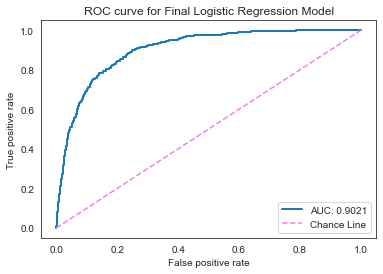

In [45]:
fpr, tpr, thresholds = roc_curve(y_test, final_model.predict_proba(X_test)[:,1])

model_auc = roc_auc_score(y_test, final_model.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2, label=f'AUC: {model_auc:.4f}')
plt.plot([0,1],[0,1],c='violet',ls='--', label='Chance Line')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Final Logistic Regression Model')
plt.legend(loc='lower right', prop={'size': 10}, frameon=True);
print("ROC AUC score on hold out test data = {:.3f}".format(roc_auc_score(y_test, final_model.predict_proba(X_test)[:,1])))
# plt.savefig('');

### Visualizing the Percentage of Actual Deadly Encounters Captured

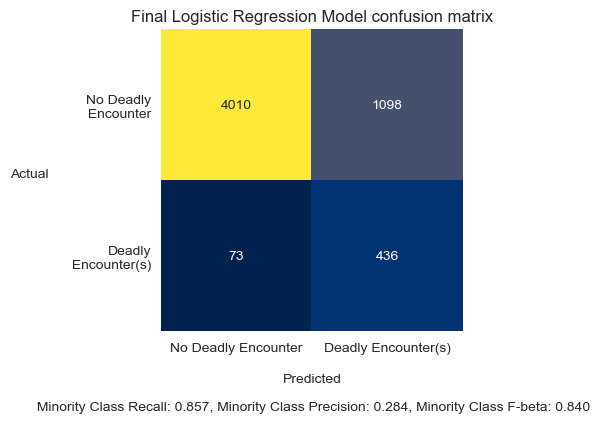

In [46]:
# Print confusion matrix for logistic regression
final_logreg_confusion = confusion_matrix(y_test, final_model.predict(X_test))
plt.figure(dpi=100)
sns.heatmap(final_logreg_confusion, fmt='d', cmap=plt.cm.cividis, annot=True, square=True, cbar=False,
           xticklabels=['No Deadly Encounter', 'Deadly Encounter(s)'],
           yticklabels=['No Deadly\n Encounter', 'Deadly\n Encounter(s)'])

# plt.xticks([1,2], labe;s)
plt.yticks(rotation=0)

plt.xlabel('\nPredicted\n\n {}, {}, {}'.format(minority_recall, minority_precision, minority_fbeta), fontsize=10)
plt.ylabel('Actual                 ', fontsize=10, rotation=0)
plt.title('Final Logistic Regression Model confusion matrix');

# Feature Importance

/Users/AmandaCheney/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/AmandaCheney/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/Users/AmandaCheney/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/model_selection/importances.py:190: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


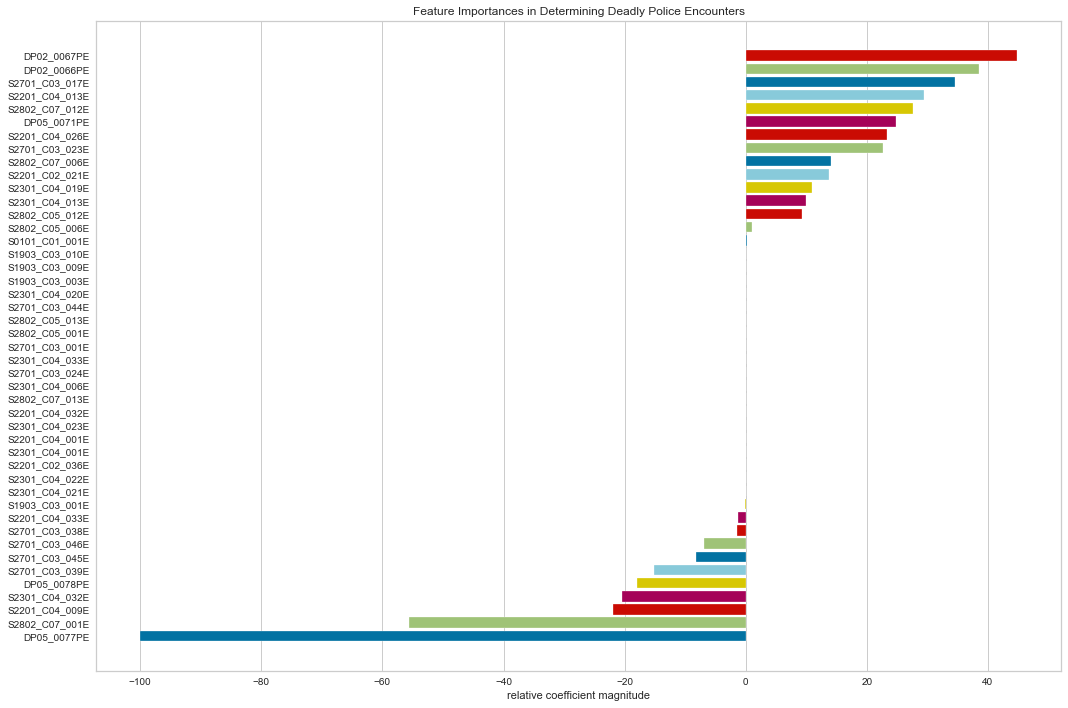

In [47]:
from yellowbrick.model_selection import FeatureImportances

figure(num=None, figsize=(15, 10), facecolor='w')

my_title = "Feature Importances in Determining Deadly Police Encounters"
visualizer = FeatureImportances(final_model, title=my_title)
visualizer.fit(X_train, y_train)

visualizer.show()
for label in visualizer.ax.texts:
    label.set_size(20);

With the full list of features clocking in at 45, and having done regulization at least half my features have gone down to zero and even if that weren't the case 48 is too high to allow for reasonable interpretability, so I will now select the top 10 most important.

In [48]:
coeffs = list(zip(X_train,final_model.coef_[0]))
len(coeffs)

45

In [49]:
test = pd.DataFrame(coeffs, columns = ['Feature', 'Coefficient'])
mine = test.iloc[(-np.abs(test['Coefficient'].values)).argsort()]
top_ten = mine[:10]
top_ten

,Feature,Coefficient
7,DP05_0077PE,-0.029433
41,S2802_C07_001E,-0.016378
9,DP02_0067PE,0.013205
8,DP02_0066PE,0.011320
11,S2701_C03_017E,0.010195
22,S2201_C04_013E,0.008641
43,S2802_C07_012E,0.008129
6,DP05_0071PE,0.007280
23,S2201_C04_026E,0.006861
12,S2701_C03_023E,0.006648


In [50]:
my_dict={
    "S2802_C07_001E":"% all households with no computer",  
    "DP02_0067PE":"% pop 25+ with Bachelor's degree or higher",  
    "DP05_0077PE": "% pop that is White (not Hispanic or Latino)",  
    "S2701_C03_017E": "% of Black pop with Health Insurance",
    "S2201_C04_013E": "% of Single Mother Households \n with children under 18 receiving SNAP",  
    "S2802_C07_012E": "% Latinx households with no computer", 
    "S2701_C03_023E": "% of Latinx pop with Health Insurance",
    "DP02_0066PE": "% pop with High School diploma or higher", 
    "DP05_0071PE": "% of pop that is Latinx",
    "S2201_C04_026E": "% of Black households receiving SNAP"
}

In [51]:
for k,v in my_dict.items():
    for i in range(len(top_ten)):
        if top_ten.iloc[i][0]==k:
            top_ten.replace(top_ten.iloc[i][0], v, inplace=True)

/Users/AmandaCheney/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [52]:
top_ten = top_ten.sort_values('Coefficient', ascending=False)
top_ten

,Feature,Coefficient
9,% pop 25+ with Bachelor's degree or higher,0.013205
8,% pop with High School diploma or higher,0.011320
11,% of Black pop with Health Insurance,0.010195
22,% of Single Mother Households \n with children...,0.008641
43,% Latinx households with no computer,0.008129
6,% of pop that is Latinx,0.007280
23,% of Black households receiving SNAP,0.006861
12,% of Latinx pop with Health Insurance,0.006648
41,% all households with no computer,-0.016378
7,% pop that is White (not Hispanic or Latino),-0.029433


In [53]:
with open('top_ten.pickle', 'wb') as to_write:
    pickle.dump(top_ten, to_write)

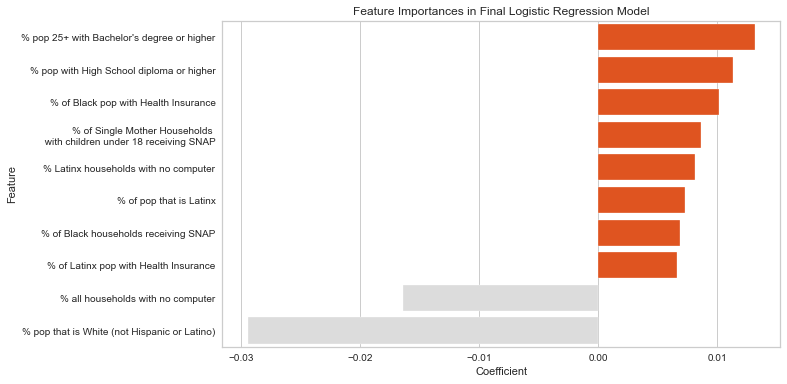

In [54]:
increase = list(top_ten.Feature[0:8])
plt.figure(figsize=(10,6))
sns.barplot(y=top_ten['Feature'], x=top_ten['Coefficient'], data=top_ten, orient='h', palette=['orangered' if y in increase else 'gainsboro' for y in top_ten.Feature])

plt.title('Feature Importances in Final Logistic Regression Model');
plt.savefig('Feature Importance');

Output the final model's predictions of the likelihood of a deadly encounter for all observations to input into Tableau visualization.

In [55]:
likelihoods_deadly_encounters = final_model.predict_proba(X)
likelihoods_deadly_encounters = pd.DataFrame(likelihoods_deadly_encounters)
likelihoods_deadly_encounters

,0,1
0,0.787879,0.212121
1,0.027707,0.972293
2,0.080092,0.919908
3,0.231799,0.768201
4,0.109497,0.890503
...,...,...
28076,0.726508,0.273492
28077,0.906099,0.093901
28078,0.413322,0.586678
28079,0.857572,0.142428


-----